# Practical Session 5 - Parallel Markov chains with multiprocessing and dask

Students (pair):
- [Student 1]([link](https://github.com/username1))
- [Student 2]([link](https://github.com/username2))


**Useful references for this lab**:

[1] `seaborn`: [official tutorial](https://seaborn.pydata.org/tutorial.html)

[2] `multiprocessing`: [documentation](https://docs.python.org/3/library/multiprocessing.html), [doc2](https://he-arc.github.io/livre-python/multiprocessing/index.html)

[3] `dask`: [documentation](http://numba.pydata.org/) 

## <a name="content">Contents</a>
- [Exercise 1: seaborn, a useful tool for data visualisation](#ex1)
- [Exercise 2: Simulating a discrete-time homogeneous Markov chain](#ex2)
- [Bonus: Parallel computing with Dask](#bonus)
---

In [24]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## <a name="ex1">Exercise 1: seaborn, a useful tool for data visualisation</a> [(&#8593;)](#content)
 
The `seaborn` package can significantly enhance data and data analysis visualization. See the [tutorial page](https://seaborn.pydata.org/tutorial.html) for examples of effective predefined graphics. An example aimed at visualizing the empirical distributions of 9 realizations of a bivariate Gaussian random vector is reported below.

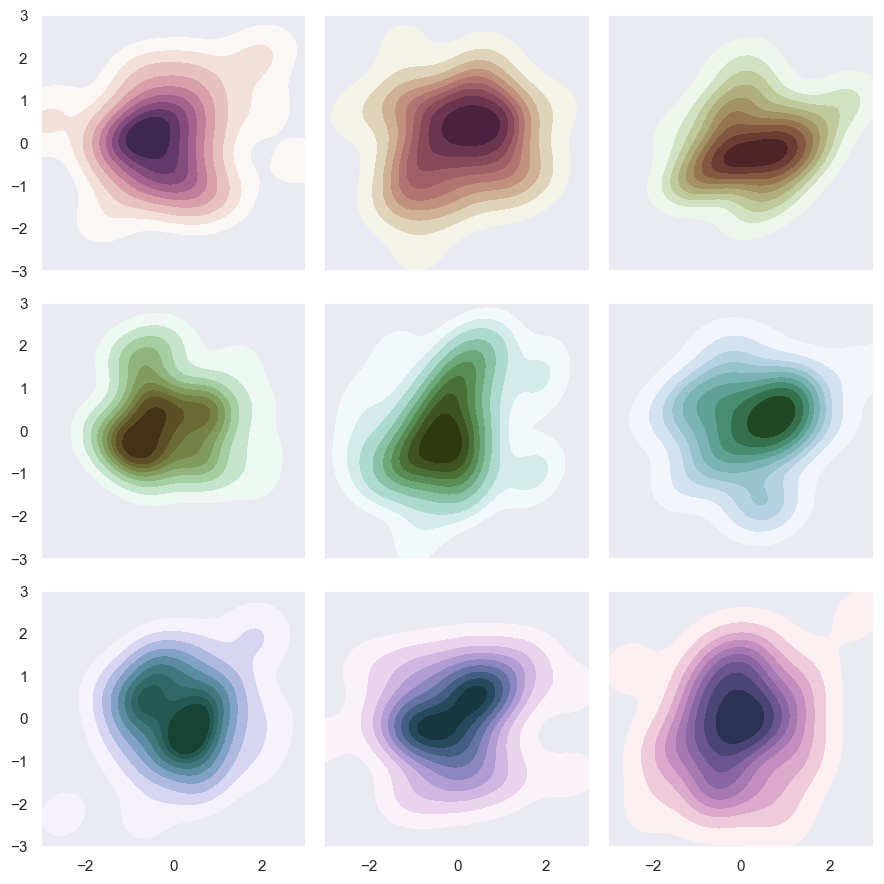

In [25]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

sns.set(style="dark")
rng = np.random.default_rng(50)

# Set up the matplotlib figure
f, axes = plt.subplots(3, 3, figsize=(9, 9), sharex=True, sharey=True)

# Rotate the starting point around the cubehelix hue circle
for ax, s in zip(axes.flat, np.linspace(0, 3, 10)):

    # Create a cubehelix colormap to use with kdeplot
    cmap = sns.cubehelix_palette(start=s, light=1, as_cmap=True)

    # Generate and plot a random bivariate dataset
    x, y = rng.normal(size=(2, 50))
    sns.kdeplot(x=x, y=y, cmap=cmap, fill=True, cut=5, ax=ax)
    ax.set(xlim=(-3, 3), ylim=(-3, 3))

f.tight_layout()

1. Comment on the lines of codes related to the `seaborn` library to make their role explicit. More specifically comment on the KDE method.

**Answer:**


- The `sns.kdeplot()` function is used to plot a kernel density estimate with optional shading. It is a bivariate plot that is useful for visualizing the density of data at different points in the x-y space. 
- The cmap parameter is used to specify the colormap to use for the plot. The fill parameter is used to specify whether to fill the area under the KDE curve. 
- The cut parameter is used to specify the number of standard deviations to consider when plotting the KDE curve. 
- The ax parameter is used to specify the axes on which to plot the KDE curve.

2. For one of the realizations, take a look at the documentation of [`sns.jointplot`](https://seaborn.pydata.org/examples/joint_kde.html) to display both the 2-D empirical distribution of the data, and 1D histograms of their distribution along each axis. 

**Answer:**

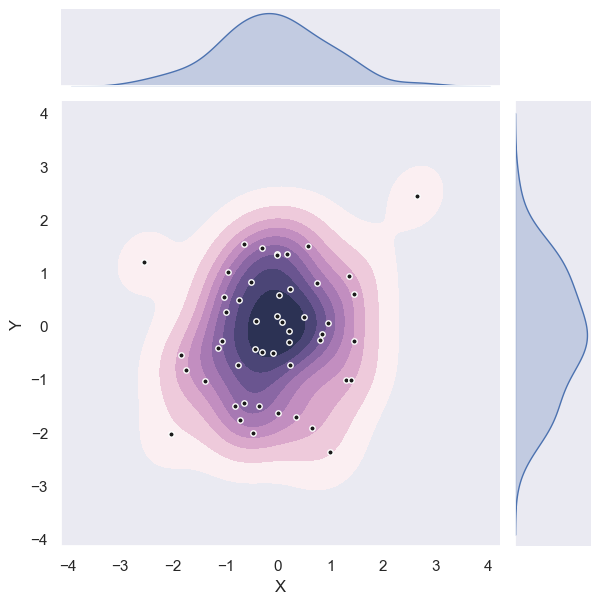

In [26]:
sns.jointplot(x=x, y=y, kind="kde", fill=True, cmap=cmap)
plt.scatter(x, y, c="k", s=15, linewidth=1, edgecolor="w", marker="o")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()

## <a name="ex2">Exercise 2: Simulating a discrete-time homogeneous Markov chain.</a> [(&#8593;)](#content)


Let ${(X_n)}_{n\geq 0}$ be a discrete-time homogeneous Markov chain with values over a finite ensemble $E=\{x_1,\dots,x_N\}$ identified to $\{1,\dots,N\}$. Consider $\boldsymbol{\rho} \in \Delta_N$, where $\Delta_N = \{\mathbf{x}\in\mathbb{R}^N \mid x_n \geq 0 \, \forall n \in \{1,\dotsc,N\} \text{ and } \sum_n x_n = 1 \}$ is the unit simplex in $\mathbb{R}^N$.

In the following, we consider the initial state of the chain $X_0$, following the discrete probability distribution:

$$
    \mathbb{P}(X_0 = k) = \rho_k, \qquad k \in \{1, \dots,  N\}.
$$
  
Let $\mathbf{A} = [a_{i,j}]_{i,j} \in \mathbb{R}^{N \times N}$ be the transition matrix of the chain, i.e.,

\begin{align*}
    &a_{i,j} = \mathbb{P}(X_{n+1} = j \mid X_{n} = i) \geq 0, \, \forall n \geq 0, \\
    &(\forall i \in \{1, \dotsc, N\}), \quad \sum_{j=1}^N a_{i,j} = 1.
\end{align*}
 
The chain is said to be homogeneous in that $\mathbf{A}$ does not depend from the time index $n$. Let $\tilde{a}_n$ represent the $n$-th row of $\mathbf{A}$. 

The trajectory of the chain can be simulated as follows:

>- Draw the discrete random variable $X_0$ with distribution $\boldsymbol{\rho}$;
>
>- For $q = 0$ to $n_{\text{iter}}-1$
>    - Draw the discrete random variable $X_{q+1}$ with distribution $\tilde{a}_{X_{q}}$;
>    
>- Return ${(X_q)}_{0 \leq q \leq n_{\text{iter}}}$.


<!-- If $X_n = k$, we know that $T$, the life time of the chain in the state $k$ obeys a geometric distribution with parameter $a_{kk}$. We also know that the probability of transition from k to $\ell\neq k$ is given by:

$$
    \mathbb{P}(X_{n+1}=\ell | X_n=k, \ell\neq k) = \frac{a_{k\ell}}{1-a_{kk}}.
$$

 ### One possible algorithm to simulate a Markov chain is therefore:

    a. generate the initial state $X_0$ according to the discrete law $\{\rho_1,\dots,\rho_N\}$.

    b. at instant $n$, knowing that $X_n=k$,

    i) determine the life time $T$ in state $X_n=k$ by simulating a geometrical variable with parameter $a_{kk}$. As a consequence $X_n = \dots = X_{n+T} = k$. When $T=0$, we simply still have $X_n=k$.

    ii) determine next transition instant $n+T$, and determine the next state by using the probabilities of transition. -->

1. Implement the above algorithm in a function `X = markov(rho,A,nmax,rng)` with:
     - `rho`: law of the initial state (nonnegative vector of size $N$, summing to 1),
     - `A`: transition matrix (of size $N\times N$) 
     - `nmax`: number of time steps,
     - `rng`: random number generator
     - `X`: trajectory of the chain.
     
In particular, check the input parameters `A` and `rho` make sense by adding appropriate assertions (or raising exceptions).
   - Examples : **transition matrix `A` should be square** ; **expected `A` to be a stochastic matrix** ; **verify if the size of `A` and `rho` are consistent** ; **verify if `rho` is in the unit simplex**
     - `np.allclose`, `np.isclose` and `np.all` could be useful

> Hints:
> - the function `np.random.choice` can be useful to draw discrete random variables.
> - use `states = np.arange(N)` to create the the labels of the states (from $0$ up to $N-1$)

Here is an example of execution : 
![alternatvie text](img/For_CourseM.png)

**Answer:**

In [27]:
def markov(rho, A, nmax, rng):

    assert len(rho) == A.shape[0] == A.shape[1]
    assert np.allclose(np.sum(A, axis=1), 1)
    assert np.allclose(np.sum(rho), 1)
    assert np.all(rho >= 0)
    assert np.all(A >= 0)
    assert nmax > 0

    N = len(rho)

    np.random.seed(rng)
    states = np.arange(N)
    X = np.zeros(nmax, dtype=int)

    X[0] = np.random.choice(states, p=rho)

    for n in range(1, nmax):
        X[n] = np.random.choice(states, p=A[X[n-1]])

    return X

2. Set the random number generator to a known state. Make a few simulations using simple transition matrices (*i.e.*, taking any nonnegative matrix $A=(a_{i,j})$ such that its lines sum to 1) and display the trajectory of the chains.

**Answer:**

In [28]:
def generate_markov_params(N, rng):
    np.random.seed(rng)
    # generate A using normal distribution
    A = np.random.rand(N, N)
    A /= np.sum(A, axis=1)[:, np.newaxis]

    # generate rho using dirichlet distribution
    rho = np.random.dirichlet(np.ones(N))
    return rho, A

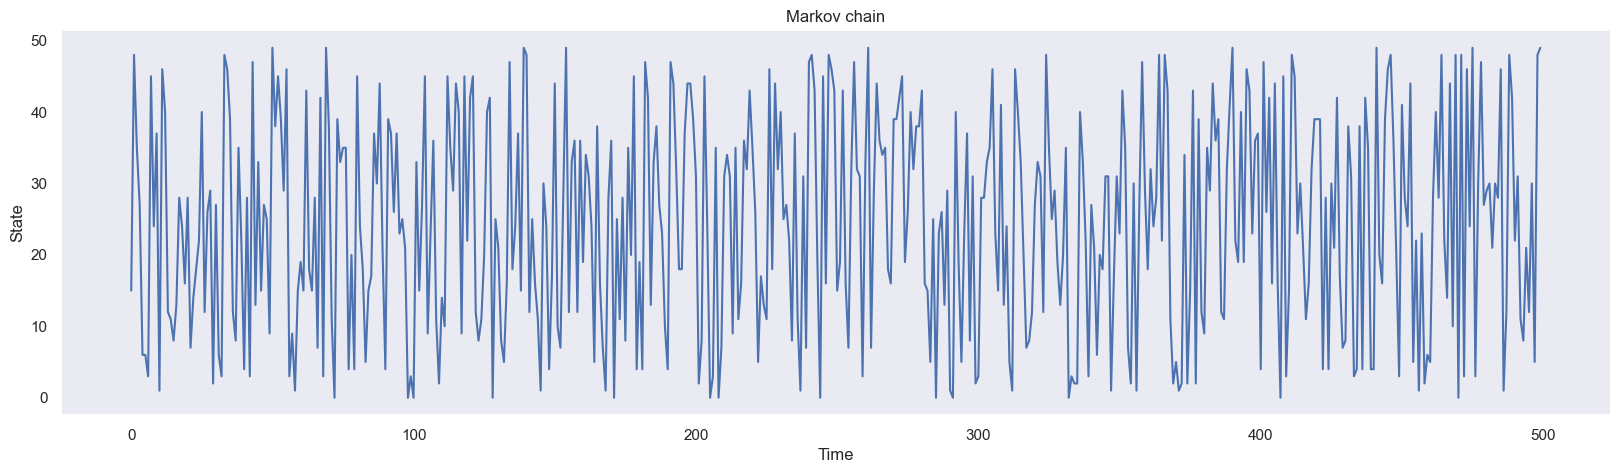

In [29]:
rng = 42
N = 50
nmax = 500
rho, A = generate_markov_params(N, rng)

X = markov(rho, A, nmax, rng)

plt.figure(figsize=(20,5),dpi=100)
plt.plot(X)
plt.xlabel("Time")
plt.ylabel("State")
plt.title("Markov chain")
plt.show()

3. Explore the potential of the [`multiprocessing` package](https://docs.python.org/3/library/multiprocessing.html) to simulate several Markov chains in parallel.

> Hint: the `mutiprocessing.Pool.starmap` or `mutiprocessing.Pool.starmap_async` methods could be useful.

In [30]:
from multiprocessing import Pool
import time

In [31]:
from  Markov import markov, generate_markov_parameters

In [32]:
num_processors = 10
p = Pool(processes=num_processors)
A, rho = generate_markov_parameters(100)

In [35]:

from multiprocessing import Pool
from Markov import markov
import time


if __name__ == '__main__':


    args_list = [(rho,A, 1000, rng) for rng in range(200)]


    start = time.time()

    with Pool(processes=5) as pool:

        results = pool.starmap(markov,args_list)

    end = time.time()

    print('Execution time with multiprocessing', end-start,'seconds')

Execution time with multiprocessing 1.7589657306671143 seconds


In [36]:
# Execution time without multiprocessing

start = time.process_time()
resultss = []
args_list = [(rho, A, 1000, rng) for rng in range(200)]
for args in args_list:
    resultss.append(markov(*args))
end = time.process_time()

print('Execution time without multiprocessing', end-start,'seconds')

Execution time without multiprocessing 2.375 seconds


- Execution Time with multiprocessing is 1.75 sec and without multiprocessing is 2.375 sec 
- Hence, multiprocessing is faster than without multiprocessing as expected. Because multiprocessing uses multiple processors to execute the code in parallel. 
- But in case we're working with small data, multiprocessing may not be faster than without multiprocessing as shown in the below example. This is Because if the task is smal the overhead of spawning processes and managing them (including context switches, synchronization, etc.) could be more significant than the time saved by parallel execution.

In [37]:

if __name__ == '__main__':


    args_list = [(rho,A, 1000, rng) for rng in range(20)]


    start = time.time()

    with Pool(processes=5) as pool:

        results = pool.starmap(markov,args_list)

    end = time.time()

    print('Execution time with multiprocessing', end-start,'seconds')

start = time.process_time()
resultss = []
args_list = [(rho, A, 1000, rng) for rng in range(20)]
for args in args_list:
    resultss.append(markov(*args))
end = time.process_time()

print('Execution time without multiprocessing', end-start,'seconds')

Execution time with multiprocessing 1.091679573059082 seconds
Execution time without multiprocessing 0.25 seconds


**Answer:**

4. [Bonus] Generate Markov chains in parallel with the [`dask`](https://docs.dask.org/en/latest/futures.html) library, which offers more general parallelization functionalities (with, for instance, the use of [`Futures`](https://docs.dask.org/en/stable/futures.html), see tutorial [here](https://tutorial.dask.org/05_futures.html)). A useful example is provided [here](https://stackoverflow.com/questions/41471248/how-to-efficiently-submit-tasks-with-large-arguments-in-dask-distributed). Note that `dask` is much more versatile and powerful than `multiprocessing`, and can be useful to scale algorithms over multiple cores and/or computing nodes.

**Answer:**

## <a name="bonus">Bonus: Parallel computing with Dask</a> [(&#8593;)](#content)

1. Take a look at the [`dask.array` documentation](https://docs.dask.org/en/stable/array-best-practices.html) and the associate [tutorial](https://tutorial.dask.org/02_array.html). Apply some of the functions introduced herein and in the [documentation](https://docs.dask.org/en/stable/array-best-practices.html) to parallelize the computation of the total variation investigated during session 2. Note that you can combine `dask` and `numba` to obtain an overall more efficient implementation. Note that timing can be worse than Numpy (`dask.array` is more specifically interesting when the data do no fit in memory).

2. Take a look at the [`dask.delayed` tutorial](https://tutorial.dask.org/03_dask.delayed.html), and go through some of the examples provided. [Best practices with the `dask.delayed` interface](https://docs.dask.org/en/stable/delayed-best-practices.html) are summarized in the documentation.

> **Remark**: an alternative to Dask: the [Ray](https://docs.ray.io/en/latest/) library.

**Answer:**

In [13]:
# your code